# Mercari NLP

In [1]:
#Standard imports
import pandas as pd
import os
import sys
import string
import re
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SKlearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#NLTK
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging

## Preproccessing

In [2]:
train_df = pd.read_csv("/Users/javm/Desktop/Mercari-Price-Prediction-Project/train.tsv", sep = '\t')

In [3]:
# Consider removing category_name values that sum up to less than 5k
train_df = train_df.groupby('category_name').filter(lambda x : len(x)>8000)

In [4]:
# Turn 'brand name' to 0s and 1s 

In [5]:
train_df['brand_name'].isna().value_counts()

False    511161
True     267576
Name: brand_name, dtype: int64

In [6]:
train_df['category_name'] = train_df['category_name'].str.replace('/', ' ')

In [7]:
# Dropped less than 10 rows
train_df.dropna(subset = ['item_description'], inplace = True)

In [8]:
# Dropped .4%. Not 40%, but .4% as in .004
train_df.dropna(subset = ['category_name'],inplace = True)

In [9]:
train_df['item_description'].isna().value_counts()

False    778736
Name: item_description, dtype: int64

In [10]:
train_df['brand_name'] = train_df['brand_name'].fillna(0)

In [11]:
train_df.isna().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [12]:
train_df['brand_mention'] = np.where(train_df['brand_name']!= 0, True,False)
train_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_mention
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men Tops T-shirts,0,10.0,1,No description yet,False
2,2,AVA-VIV Blouse,1,Women Tops & Blouses Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,True
3,3,Leather Horse Statues,1,Home Home Décor Home Décor Accents,0,35.0,1,New with tags. Leather horses. Retail for [rm]...,False
4,4,24K GOLD plated rose,1,Women Jewelry Necklaces,0,44.0,0,Complete with certificate of authenticity,False
6,6,Acacia pacific tides santorini top,3,Women Swimwear Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,True
...,...,...,...,...,...,...,...,...,...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women Tops & Blouses T-Shirts,0,12.0,0,"Great Harry Potter Shirt! ""Hogwarts, School of...",False
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women Tops & Blouses Blouse,0,10.0,1,Brand new black and white ribbed mock neck bod...,False
1482528,1482528,Victoria's Secret Tankini Sz. Large,2,Women Athletic Apparel Sports Bras,Victoria's Secret,18.0,1,Purple and Paisley Victoria's Secret Tankini S...,True
1482533,1482533,World markets lanterns,3,Home Home Décor Home Décor Accents,0,45.0,1,There is 2 of each one that you see! So 2 red ...,False


In [13]:
one_hot_df = pd.get_dummies(train_df, prefix="brand_mention", 
                            columns=["brand_mention"], 
                            drop_first=True)

In [14]:
one_hot_df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_mention_True
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men Tops T-shirts,0,10.0,1,No description yet,0
2,2,AVA-VIV Blouse,1,Women Tops & Blouses Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1
3,3,Leather Horse Statues,1,Home Home Décor Home Décor Accents,0,35.0,1,New with tags. Leather horses. Retail for [rm]...,0
4,4,24K GOLD plated rose,1,Women Jewelry Necklaces,0,44.0,0,Complete with certificate of authenticity,0
6,6,Acacia pacific tides santorini top,3,Women Swimwear Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,1
...,...,...,...,...,...,...,...,...,...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women Tops & Blouses T-Shirts,0,12.0,0,"Great Harry Potter Shirt! ""Hogwarts, School of...",0
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women Tops & Blouses Blouse,0,10.0,1,Brand new black and white ribbed mock neck bod...,0
1482528,1482528,Victoria's Secret Tankini Sz. Large,2,Women Athletic Apparel Sports Bras,Victoria's Secret,18.0,1,Purple and Paisley Victoria's Secret Tankini S...,1
1482533,1482533,World markets lanterns,3,Home Home Décor Home Décor Accents,0,45.0,1,There is 2 of each one that you see! So 2 red ...,0


In [15]:
one_hot_df.drop(columns = ['brand_name'], axis = 1, inplace = True)

In [16]:
#Drop rows with no item description
data = one_hot_df[one_hot_df['item_description'].str.contains('No description yet') == False]

In [17]:
data.isna().sum()

train_id              0
name                  0
item_condition_id     0
category_name         0
price                 0
shipping              0
item_description      0
brand_mention_True    0
dtype: int64

In [18]:
sample_df = data.sample(n=250000, random_state = 42)

In [19]:
sample_df.set_index('train_id', inplace = True)

In [20]:
sample_df.isna().sum()

name                  0
item_condition_id     0
category_name         0
price                 0
shipping              0
item_description      0
brand_mention_True    0
dtype: int64

In [21]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    sentiment_dict['compound']  
    return(sentiment_dict['compound'])
#     print("Overall sentiment dictionary is : ", sentiment_dict['compound'])
#     print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
#     print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
#     print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
#     print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
#     if sentiment_dict['compound'] >= 0.05 :
#         print("Positive")
 
#     elif sentiment_dict['compound'] <= - 0.05 :
#         print("Negative")
 
#     else :
#         print("Neutral")
 
 
   
# Driver code
if __name__ == "__main__" :
 
    print("\n1st statement :")
    sentence = "Geeks For Geeks is the best portal for \
                the computer science engineering students."
 
    # function calling
    sentiment_scores(sentence)
 
    print("\n2nd Statement :")
    sentence = "study is going on as usual"
    sentiment_scores(sentence)
 
    print("\n3rd Statement :")
    sentence = "I am very sad today."
    sentiment_scores(sentence)


1st statement :

2nd Statement :

3rd Statement :


In [22]:
sentence

'I am very sad today.'

In [23]:
ss = sentiment_scores(sentence)

In [24]:
ss

-0.5256

In [25]:
sample_df['compund_sentiment'] = sample_df['item_description'].apply(lambda x: sentiment_scores(x) )

In [26]:
sample_df

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment
train_id,,,,,,,,
910438,Nike air max! Size 13 in men,3,Men Shoes Athletic,46.0,1,Great color blue navy and gold! In great condi...,1,0.8925
260235,On Hold For Chelsie Bower,3,Women Sweaters Hooded,28.0,0,Ladies XL Under Armour Storm Hoodie Like new c...,1,0.0772
1430870,OASICS GEL RUNNING SHOES 8,4,Women Shoes Athletic,16.0,0,Barely used shoes but still works,1,0.0000
752938,2 bracelets,2,Women Jewelry Bracelets,45.0,1,Juste du Clau ( nail bracelets) is rose gold.....,1,0.6380
1443063,Very Sexy 32dd Crystal Push Up Bra,1,Women Underwear Bras,24.0,0,Victoria's Secret BNWT Red rhinestone crystals...,1,0.8122
...,...,...,...,...,...,...,...,...
906624,Rae Dunn I woke up like this,1,Home Kitchen & Dining Coffee & Tea Accessories,34.0,0,New set of two mugs Will ship with bubble wrap...,1,0.8364
982272,⚡free shipping bebe top⚡,3,Women Tops & Blouses Blouse,10.0,1,Size S in great condition. Authentic There's a...,1,0.8442
652951,Michael Kors boots size 7,3,Women Shoes Boots,40.0,1,Brown leather Gold hardware Worn one time but ...,1,0.2960


In [27]:
sample_df['compound_sentiment_desc'] =  sample_df['compund_sentiment']

In [28]:
vader_df = sample_df

In [29]:
vader_df.drop(columns = ['compund_sentiment'], inplace = True)

In [30]:
vader_df.isna().sum()

name                       0
item_condition_id          0
category_name              0
price                      0
shipping                   0
item_description           0
brand_mention_True         0
compound_sentiment_desc    0
dtype: int64

In [31]:
vader_df.to_csv('vad',index=False)

In [32]:
vader_df.groupby('item_condition_id').mean()

,price,shipping,brand_mention_True,compound_sentiment_desc
item_condition_id,,,,
1,27.443112,0.577497,0.557156,0.369798
2,28.047174,0.381239,0.713794,0.344691
3,27.550928,0.353968,0.746347,0.386424
4,25.357606,0.320656,0.780461,0.290176
5,35.677262,0.325183,0.828851,0.084611


In [33]:
vader_df = pd.read_csv('/Users/javm/Desktop/Mercari-Price-Prediction-Project/vad')

In [34]:
vader_df

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
0,Nike air max! Size 13 in men,3,Men Shoes Athletic,46.0,1,Great color blue navy and gold! In great condi...,1,0.8925
1,On Hold For Chelsie Bower,3,Women Sweaters Hooded,28.0,0,Ladies XL Under Armour Storm Hoodie Like new c...,1,0.0772
2,OASICS GEL RUNNING SHOES 8,4,Women Shoes Athletic,16.0,0,Barely used shoes but still works,1,0.0000
3,2 bracelets,2,Women Jewelry Bracelets,45.0,1,Juste du Clau ( nail bracelets) is rose gold.....,1,0.6380
4,Very Sexy 32dd Crystal Push Up Bra,1,Women Underwear Bras,24.0,0,Victoria's Secret BNWT Red rhinestone crystals...,1,0.8122
...,...,...,...,...,...,...,...,...
249995,Rae Dunn I woke up like this,1,Home Kitchen & Dining Coffee & Tea Accessories,34.0,0,New set of two mugs Will ship with bubble wrap...,1,0.8364
249996,⚡free shipping bebe top⚡,3,Women Tops & Blouses Blouse,10.0,1,Size S in great condition. Authentic There's a...,1,0.8442
249997,Michael Kors boots size 7,3,Women Shoes Boots,40.0,1,Brown leather Gold hardware Worn one time but ...,1,0.2960
249998,Clemson shirt,2,Women Tops & Blouses T-Shirts,14.0,0,Women's clemson shirt Size medium Never worn,0,0.2235


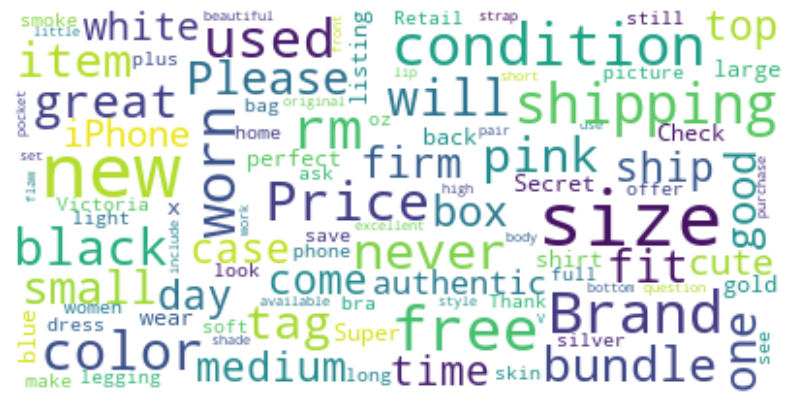

In [35]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
text = ''.join(i for i in vader_df.item_description)
wordcloud = WordCloud(stopwords = stopwords, max_font_size=40, collocations=False, background_color='white', max_words = 100).generate(text)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [36]:
vader_df.groupby('item_condition_id').mean()

,price,shipping,brand_mention_True,compound_sentiment_desc
item_condition_id,,,,
1,27.443112,0.577497,0.557156,0.369798
2,28.047174,0.381239,0.713794,0.344691
3,27.550928,0.353968,0.746347,0.386424
4,25.357606,0.320656,0.780461,0.290176
5,35.677262,0.325183,0.828851,0.084611


## Conditions

In [37]:
condition_1 = vader_df[vader_df['item_condition_id'] == 1]

In [8]:
condition_1

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
4,Very Sexy 32dd Crystal Push Up Bra,1,Women Underwear Bras,24.0,0,Victoria's Secret BNWT Red rhinestone crystals...,1,0.8122
5,Tory burch perfume,1,Beauty Fragrance Women,89.0,0,NWT never opened box. Tory burch perfume 3.4 f...,0,0.0000
10,NWT AE Chunky Cable Knit Cardigan XS/S,1,Women Sweaters Cardigan,24.0,1,Brand new AE sweater cardigan. Beautiful chunk...,1,0.8789
15,Estée Lauder Long Lasting Lipstick Set,1,Beauty Makeup Lips,15.0,1,"Brand New - With this listing, you are getting...",1,0.5562
18,NYX HD FINISHING POWDER IN BANANA NEW,1,Beauty Makeup Face,20.0,0,New Banana Pressed powder NYX concealer in lig...,1,-0.4640
...,...,...,...,...,...,...,...,...
499989,Marvel Legends Weapon X (Wolverine),1,Kids Toys Action Figures & Statues,46.0,0,Marvel Legends Weapon X (Wolverine). Don't mis...,1,0.8026
499992,Samsung Galaxy express prime,1,Electronics Cell Phones & Accessories Cell Pho...,50.0,1,Will it's brand new and the color is black and...,1,0.7896
499994,⚡️free ship 4 pink logo boyshorts ⚡️m,1,Women Underwear Panties,32.0,1,For all 4 pairs Nwt Size m,1,0.0000
499996,ItWorks! Green Chews,1,Beauty Skin Care Body,22.0,1,"ItWorks! Green Chews, never opened. I do not s...",0,-0.4184


In [9]:
condition_2 = vader_df[vader_df['item_condition_id'] == 2]

In [10]:
condition_2

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
3,2 bracelets,2,Women Jewelry Bracelets,45.0,1,Juste du Clau ( nail bracelets) is rose gold.....,1,0.6380
7,Lularoe Amelia dress,2,Women Dresses Knee-Length,36.0,0,Never worn but no tags- great condition.,1,-0.3950
8,Huraches,2,Men Shoes Athletic,66.0,0,Black and red Huraches size 10.5 only worn onc...,1,0.1779
9,Ralph Lauren Quilted Jacket,2,Women Athletic Apparel Jackets,31.0,0,Ralph Lauren Quilted Jacket in great used cond...,1,0.6249
13,Women's tank top,2,"Women Tops & Blouses Tank, Cami",7.0,1,"Navy blue tank top with adjustable straps, siz...",0,0.8908
...,...,...,...,...,...,...,...,...
499973,iPhone 6,2,Electronics Cell Phones & Accessories Cell Pho...,125.0,1,Carrier is sprint,1,0.0000
499977,Lululemon Speed Shorts,2,Women Athletic Apparel Shorts,39.0,0,Grey Excellent condition,1,0.5994
499980,2 vs pink bralettes sz small,2,Women Underwear Bras,7.0,0,Lace vs pink bralettes both sz small 1 clip fr...,1,0.0000
499990,Lorca Mega Pro,2,Beauty Makeup Makeup Palettes,30.0,1,"Gently used. Only used the color Goji, Caberne...",1,0.8122


In [11]:
condition_3 = vader_df[vader_df['item_condition_id'] == 3]
condition_3

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
0,Nike air max! Size 13 in men,3,Men Shoes Athletic,46.0,1,Great color blue navy and gold! In great condi...,1,0.8925
1,On Hold For Chelsie Bower,3,Women Sweaters Hooded,28.0,0,Ladies XL Under Armour Storm Hoodie Like new c...,1,0.0772
6,Luigi's Mansion: Dark Moon Nintendo 3DS,3,Electronics Video Games & Consoles Games,17.0,1,"In great condition w/o case N3DS game, tested ...",1,0.8910
11,*Bundle For KTB Only*,3,Beauty Fragrance Women,36.0,0,Bundle 4 KTB only of fragrance & Victoria Secr...,0,0.5499
16,Lululemon size small,3,Women Athletic Apparel Sports Bras,14.0,0,❌NO FREE SHIPPING❌ ❌NO FREE SHIPPING❌ n ~ LuLu...,1,0.9325
...,...,...,...,...,...,...,...,...
499986,Torrid 9 wide sandals,3,Women Shoes Sandals,10.0,1,"WIDE. Super comfortable, lots of padding. Blac...",1,0.8658
499987,Women's Lane Bryant Blouse,3,Women Tops & Blouses Blouse,18.0,0,Lane Bryant Size: 22/24 100% Polyester Made in...,1,0.6249
499993,Victoria's Secret Pink T-Shirt,3,Women Tops & Blouses T-Shirts,10.0,0,size: XS,1,0.0000
499997,Coach authentic wallet,3,Women Women's Accessories Wallets,34.0,0,"Purchased brand new, wallet was never used, ex...",1,-0.4585


In [12]:
condition_4 = vader_df[vader_df['item_condition_id'] == 4]
condition_4

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
2,OASICS GEL RUNNING SHOES 8,4,Women Shoes Athletic,16.0,0,Barely used shoes but still works,1,0.0000
132,FREE SHIP Statement Bow Necklaces Set,4,Women Jewelry Necklaces,8.0,1,Black necklace: length- 9.5 inches with 3 inch...,0,0.4588
137,Black pink bra Victoria secret,4,Women Underwear Bras,10.0,0,Black bra fair condition 32 B,1,0.3182
212,Lululemon crop pant,4,"Women Athletic Apparel Pants, Tights, Leggings",14.0,1,Well loved crop pant with slit up calf,1,0.7184
220,Nike Pro,4,Women Athletic Apparel Shorts,14.0,0,Spandex. Cracks in the Nike symbol,1,0.0000
...,...,...,...,...,...,...,...,...
499790,VICTORIA'S SECRET PINK BAYLOR HOODIE,4,Women Sweaters Hooded,18.0,0,SIZE L,1,0.4588
499877,Lululemon speed shorts size 6,4,Women Athletic Apparel Shorts,20.0,1,Good condition. No rips or holes but some wear...,1,0.0900
499967,Levis jeggings. Size 27,4,"Women Jeans Slim, Skinny",8.0,0,Dark wash. Super stretchy. Only defect is 2 te...,1,0.9827
499975,One Direction Perfume,4,Beauty Fragrance Women,7.0,0,Full without box One direction our moment This...,0,0.3400


In [13]:
condition_5 = vader_df[vader_df['item_condition_id'] == 5]
condition_5

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
12,Iphone 6 (FOR PARTS ONLY),5,Electronics Cell Phones & Accessories Cell Pho...,54.0,0,Iphone 6 for parts only. Screen has a crack bu...,1,0.0000
430,Rose Gold iPhone 6S,5,Electronics Cell Phones & Accessories Cell Pho...,150.0,1,Screen is shattered Rose Gold At&t 64 GB Phone...,1,-0.4767
1232,IPhone 6 Plus FOR PARTS!,5,Electronics Cell Phones & Accessories Cell Pho...,45.0,1,Phone doesnt turn on Screen shattered For part...,1,-0.7003
2038,Water Damaged Moto G,5,Electronics Cell Phones & Accessories Cell Pho...,7.0,0,"It was washed in a washing machine, don't know...",0,0.0000
2524,Sprint IPhone6 crked scrn carrier locked,5,Electronics Cell Phones & Accessories Cell Pho...,81.0,0,Can be unlocked Not iPhone locked Not icloud l...,1,-0.5927
...,...,...,...,...,...,...,...,...
497175,Infared 6s,5,Men Shoes Athletic,26.0,0,"These 6s are a little beat up , I repainted th...",1,-0.8101
497691,Samsung galaxy s3 16GB (broken),5,Electronics Cell Phones & Accessories Cell Pho...,24.0,0,Has a slightly cracked screen and a small dent...,1,0.3903
498216,Coach shoulder tote with pink bow,5,Women Women's Handbags Shoulder Bag,22.0,0,Authentic coach shoulder tote with pink bow ti...,1,0.0000
498877,2 iPhone 4's!,5,Electronics Cell Phones & Accessories Cell Pho...,20.0,1,Eager to sell! The one with a missing home but...,1,0.5093


In [31]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging

In [14]:
def process_text(clean_text, min_length):
    
    stop_words = stopwords.words('english')
    wnl = WordNetLemmatizer()
    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        # elif nltk_tag.startswith('N'):
        #     return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    clean_lower = clean_text.lower()

#     #remove mentions, hashtags, and urls, strip whitspace and breaks
#     tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(clean_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return text_norm

In [15]:
condition_5['item_description'] = condition_5['item_description'].apply(process_text, args = [1])

/var/folders/6g/zn0bw_6s1ws2qwbb44k4ppkw0000gn/T/ipykernel_30212/3213708838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_5['item_description'] = condition_5['item_description'].apply(process_text, args = [1])


In [16]:
condition_5

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc
12,Iphone 6 (FOR PARTS ONLY),5,Electronics Cell Phones & Accessories Cell Pho...,54.0,0,screen fully functional activate,1,0.0000
430,Rose Gold iPhone 6S,5,Electronics Cell Phones & Accessories Cell Pho...,150.0,1,shatter rise gold,1,-0.4767
1232,IPhone 6 Plus FOR PARTS!,5,Electronics Cell Phones & Accessories Cell Pho...,45.0,1,turn shatter tell logic damage research replac...,1,-0.7003
2038,Water Damaged Moto G,5,Electronics Cell Phones & Accessories Cell Pho...,7.0,0,washed wash know replace use prop,0,0.0000
2524,Sprint IPhone6 crked scrn carrier locked,5,Electronics Cell Phones & Accessories Cell Pho...,81.0,0,unlocked lock icloud lock need new update soon...,1,-0.5927
...,...,...,...,...,...,...,...,...
497175,Infared 6s,5,Men Shoes Athletic,26.0,0,little repaint bottom best still wear,1,-0.8101
497691,Samsung galaxy s3 16GB (broken),5,Electronics Cell Phones & Accessories Cell Pho...,24.0,0,slightly crack small back turn sell welcome,1,0.3903
498216,Coach shoulder tote with pink bow,5,Women Women's Handbags Shoulder Bag,22.0,0,authentic pink strap heavily use many bottom c...,1,0.0000
498877,2 iPhone 4's!,5,Electronics Cell Phones & Accessories Cell Pho...,20.0,1,sell miss definitely negotiable come,1,0.5093


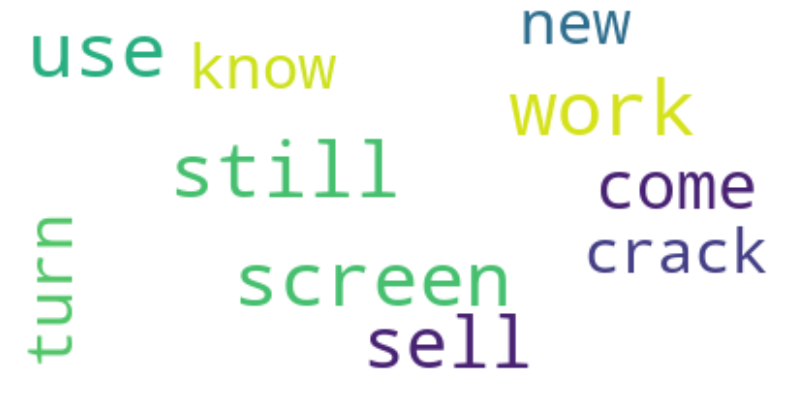

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
text = ''.join(i for i in condition_5.item_description)
wordcloud = WordCloud(stopwords = stopwords, max_font_size=40, collocations=False, background_color='white', max_words = 10).generate(text)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
condition_1['item_description'] = condition_1['item_description'].apply(process_text, args = [1])

/var/folders/6g/zn0bw_6s1ws2qwbb44k4ppkw0000gn/T/ipykernel_30212/3179660544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_1['item_description'] = condition_1['item_description'].apply(process_text, args = [1])


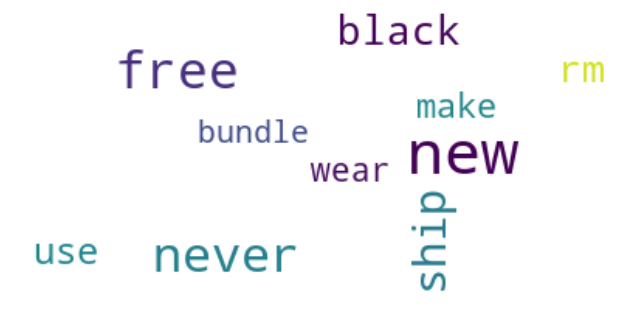

In [35]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
text = ''.join(i for i in condition_1.item_description)
wordcloud = WordCloud(stopwords = stopwords, max_font_size=40, collocations=False, background_color='white', max_words = 10).generate(text)
plt.figure( figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [32]:
condition_3['item_description'] = condition_3['item_description'].apply(process_text, args = [1])

/var/folders/6g/zn0bw_6s1ws2qwbb44k4ppkw0000gn/T/ipykernel_30212/3527791329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_3['item_description'] = condition_3['item_description'].apply(process_text, args = [1])


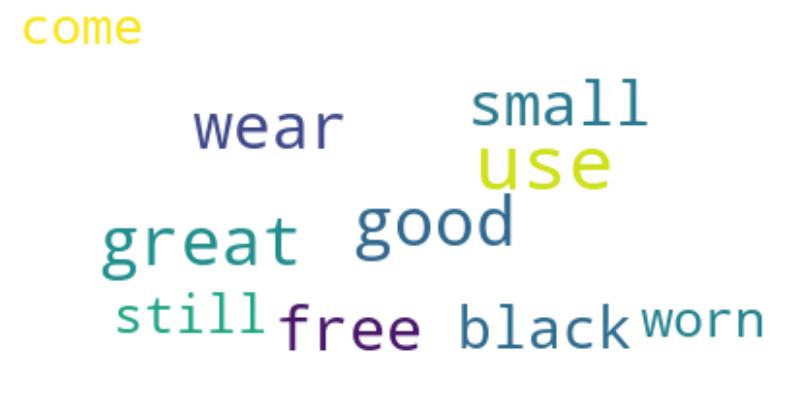

In [34]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
text = ''.join(i for i in condition_3.item_description)
wordcloud = WordCloud(stopwords = stopwords, max_font_size=40, collocations=False, background_color='white', max_words = 10).generate(text)
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()